In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Set working directory (dataset directory)
data_dir = '/content/drive/MyDrive/Fed_auth'
file_path = "/content/drive/MyDrive/Fed_auth/f9cc94d7-a74f-4747-999f-04d4dca1c27c/audio/audio_0.mp3"

/tmp/ipython-input-2629647151.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=None)  # Keep original sampling rate
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


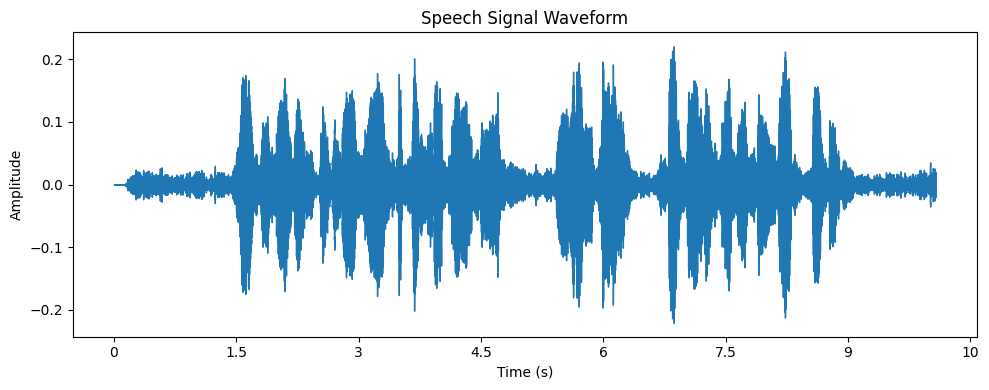

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

signal, sr = librosa.load(file_path, sr=None)  # Keep original sampling rate

plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Speech Signal Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Found 33 subjects. Expecting 3 recordings per subject.


/tmp/ipython-input-1457764250.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_orig = librosa.load(path, sr=sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1457764250.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_orig = librosa.load(path, sr=sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1457764250.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_orig = librosa.load(path, sr=sr)
/usr/local/lib/python3.12/dist-packages/librosa/cor

Feature matrix: (99, 180) Labels: (99,)
[Fold 0] Accuracy: 0.9394 (test size=33)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 1] Accuracy: 0.9394 (test size=33)
[Fold 2] Accuracy: 1.0000 (test size=33)
✅ Mean 3-fold subject-ID accuracy: 0.9596


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-1457764250.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr_orig = librosa.load(path, sr=sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


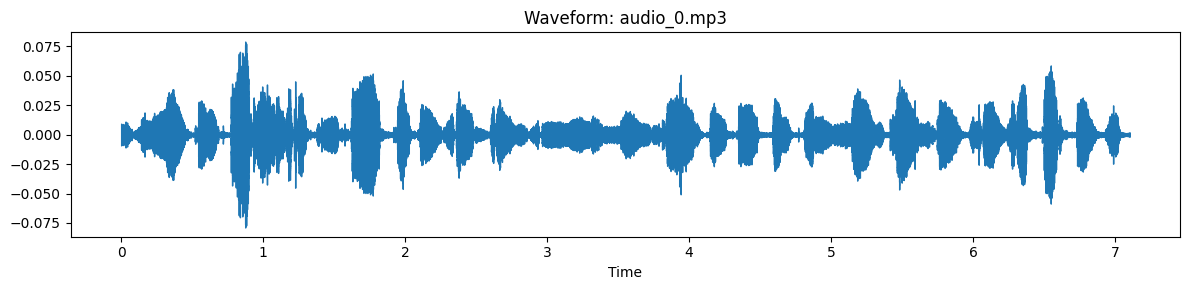

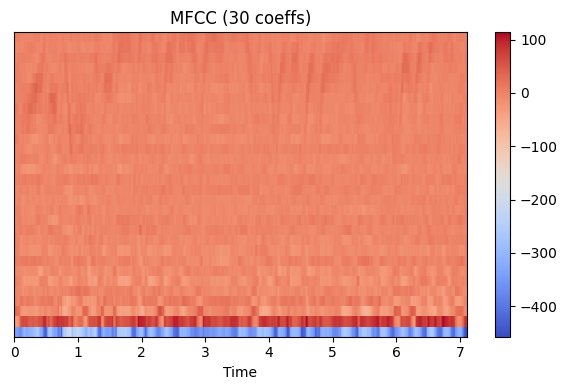

In [7]:
# =========================================
# Speaker (Subject) Identification Pipeline
# =========================================
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# ---------------------------
# Config
# ---------------------------
# Assumed dataset layout:
# /content/drive/MyDrive/Fed_auth/<subject_id>/audio/audio_0.mp3
#                                                     audio_1.mp3
#                                                     audio_2.mp3
DATA_ROOT = "/content/drive/MyDrive/Fed_auth"
AUDIO_SUBDIR = "audio"
SR_TARGET = 16000        # resample for stable feature extraction
N_MFCC = 30              # MFCC count
N_MELS = 64              # mel bins (used to compute MFCC)
HOP_LENGTH = 160         # 10 ms hop at 16kHz
N_FFT = 1024             # ~64 ms window
PREEMPH = 0.97           # pre-emphasis coefficient
VAD_TOP_DB = 20          # silence trim threshold (smaller -> more trimming)
SEED = 42

# ---------------------------
# Utils: audio loading & features
# ---------------------------
def load_audio(path, sr=SR_TARGET):
    """Load audio and resample to sr."""
    y, sr_orig = librosa.load(path, sr=sr)
    # Pre-emphasis (cheap high-pass to emphasize speaker characteristics)
    y = np.append(y[0], y[1:] - PREEMPH * y[:-1])
    # Simple silence removal (VAD) to reduce long pauses)
    # Each segment above threshold is kept; then concatenated
    intervals = librosa.effects.split(y, top_db=VAD_TOP_DB)
    if len(intervals) > 0:
        y_voiced = np.concatenate([y[s:e] for s, e in intervals])
    else:
        y_voiced = y
    return y_voiced, sr

def extract_mfcc_stats(y, sr):
    """
    Extract MFCC + delta + delta-delta features, then stats-pool over time.
    Output: fixed-length vector (mean+std for each coefficient set).
    """
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )  # shape (N_MFCC, T_frames)

    # Delta features
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)

    # Stack: (3*N_MFCC, T_frames)
    feats = np.vstack([mfcc, d1, d2])

    # Stats pooling: mean & std over time for each coefficient
    mean_vec = feats.mean(axis=1)
    std_vec  = feats.std(axis=1)
    emb = np.concatenate([mean_vec, std_vec])  # shape (2 * 3 * N_MFCC) = 180 if N_MFCC=30
    return emb.astype(np.float32)

def find_subjects(root=DATA_ROOT):
    """
    Discover subject directories that contain an 'audio' subfolder and 3 mp3 files.
    Returns list of dicts {'subject_id': <name>, 'files': [list of 3 paths]}
    """
    subjects = []
    for sdir in sorted(glob.glob(os.path.join(root, "*"))):
        audio_dir = os.path.join(sdir, AUDIO_SUBDIR)
        if not os.path.isdir(audio_dir):
            continue
        files = sorted(glob.glob(os.path.join(audio_dir, "audio_*.mp3")))
        if len(files) >= 3:  # at least 3; we will take first 3
            subjects.append({"subject_id": os.path.basename(sdir), "files": files[:3]})
    return subjects

# ---------------------------
# Build dataset (features + labels)
# ---------------------------
def build_feature_dataset():
    subjects = find_subjects(DATA_ROOT)
    assert len(subjects) > 0, "No subjects found. Check DATA_ROOT structure."

    X_list, y_list, meta_list = [], [], []

    # Map subject_id string -> integer class index
    subj_to_idx = {subj["subject_id"]: i for i, subj in enumerate(subjects)}
    print(f"Found {len(subjects)} subjects. Expecting 3 recordings per subject.")

    for subj in subjects:
        sid_str = subj["subject_id"]
        sid = subj_to_idx[sid_str]
        files = subj["files"]
        if len(files) < 3:
            print(f"Warning: subject {sid_str} has only {len(files)} files, skipping.")
            continue

        for rec_idx, fpath in enumerate(files):
            try:
                y, sr = load_audio(fpath, sr=SR_TARGET)
                emb = extract_mfcc_stats(y, sr)
                X_list.append(emb)
                y_list.append(sid)
                meta_list.append({"subject": sid_str, "rec_idx": rec_idx, "path": fpath, "frames": len(y)})
            except Exception as e:
                print(f"Failed: {fpath} -> {e}")

    X = np.vstack(X_list)           # (33*3, 180) ideally
    y = np.array(y_list, dtype=int) # (33*3,)
    print("Feature matrix:", X.shape, "Labels:", y.shape)
    return X, y, meta_list, subj_to_idx

# ---------------------------
# Train & evaluate (3-fold: leave one recording out per subject)
# ---------------------------
def split_by_subject_record(meta_list):
    """
    Returns indices grouped by subject with 3 entries each.
    """
    from collections import defaultdict
    groups = defaultdict(list)
    for i, m in enumerate(meta_list):
        groups[m["subject"]].append(i)
    # Ensure exactly 3 per subject
    for sid, idxs in groups.items():
        if len(idxs) != 3:
            print(f"Subject {sid} has {len(idxs)} recordings (expected 3).")
    return groups

def evaluate_three_fold(X, y, meta_list):
    groups = split_by_subject_record(meta_list)
    # Build three folds: for each subject, choose which recording index (0/1/2) is test
    folds = {0: [], 1: [], 2: []}  # will store (train_indices, test_indices)
    for test_rec in (0, 1, 2):
        train_idx, test_idx = [], []
        for sid, idxs in groups.items():
            if len(idxs) < 3:
                continue
            # Ensure consistent ordering by rec_idx
            idxs_sorted = sorted(idxs, key=lambda i: meta_list[i]["rec_idx"])
            test_idx.append(idxs_sorted[test_rec])
            train_idx.extend([idxs_sorted[k] for k in [0, 1, 2] if k != test_rec])
        folds[test_rec] = (np.array(train_idx), np.array(test_idx))

    results = []
    for fold_id, (train_idx, test_idx) in folds.items():
        Xtr, ytr = X[train_idx], y[train_idx]
        Xte, yte = X[test_idx], y[test_idx]

        # Standardize features
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)

        # Multinomial logistic regression (robust baseline)
        clf = LogisticRegression(
            penalty="l2", C=1.0, solver="lbfgs",
            multi_class="multinomial", max_iter=2000, random_state=SEED
        )
        clf.fit(Xtr_s, ytr)

        yhat = clf.predict(Xte_s)
        acc = accuracy_score(yte, yhat)
        print(f"[Fold {fold_id}] Accuracy: {acc:.4f} (test size={len(yte)})")
        results.append({"fold": fold_id, "acc": acc, "y_true": yte, "y_pred": yhat})

    mean_acc = np.mean([r["acc"] for r in results])
    print(f"Mean 3-fold subject-ID accuracy: {mean_acc:.4f}")
    return results

# ---------------------------
# Optional: visualize one waveform & MFCCs
# ---------------------------
def plot_example(meta_list):
    # pick first entry
    example_path = meta_list[0]["path"]
    y, sr = load_audio(example_path, sr=SR_TARGET)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(example_path)}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    librosa.display.specshow(mfcc, x_axis="time", sr=sr, hop_length=HOP_LENGTH)
    plt.colorbar()
    plt.title("MFCC ({} coeffs)".format(N_MFCC))
    plt.tight_layout()
    plt.show()

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    # If in Colab, ensure Drive is mounted:
    # from google.colab import drive
    # drive.mount('/content/drive')

    X, y, meta, subj_map = build_feature_dataset()
    results = evaluate_three_fold(X, y, meta)
    plot_example(meta)

**Transfer learning (ECAPA‑TDNN embeddings + linear classifier)**

In [9]:
# ============================
# Speaker ID via ECAPA embeddings
# ============================
!pip -q install speechbrain torchaudio

import os, glob, numpy as np, torch, torchaudio
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from speechbrain.pretrained import EncoderClassifier

# ---------------------------
# Dataset discovery (expects: /root/<subject_id>/audio/audio_0.mp3 ... audio_2.mp3)
# ---------------------------
DATA_ROOT = "/content/drive/MyDrive/Fed_auth"
AUDIO_SUBDIR = "audio"

def discover_dataset(data_root=DATA_ROOT):
    items = []  # each: dict(subject_id, rec_idx, path)
    subjects = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])
    for sdir in subjects:
        sid = os.path.basename(sdir)
        adir = os.path.join(sdir, AUDIO_SUBDIR)
        if not os.path.isdir(adir):
            continue
        files = sorted(glob.glob(os.path.join(adir, "audio_*.mp3")))
        # enforce three by index if possible
        for f in files:
            # parse rec_idx from filename ..._X.mp3
            stem = os.path.splitext(os.path.basename(f))[0]
            try:
                rec_idx = int(stem.split("_")[-1])
            except:
                # fallback = enumerate order (not robust)
                rec_idx = 0
            items.append({"subject": sid, "rec_idx": rec_idx, "path": f})
    # keep only first 3 per subject in rec_idx order
    from collections import defaultdict
    grouped = defaultdict(list)
    for it in items:
        grouped[it["subject"]].append(it)
    final = []
    for sid, arr in grouped.items():
        arr_sorted = sorted(arr, key=lambda x: x["rec_idx"])
        final.extend(arr_sorted[:3])
    return final

items = discover_dataset(DATA_ROOT)
subjects = sorted(list({it["subject"] for it in items}))
print(f"Found {len(subjects)} subjects, total files: {len(items)}")

sid_to_idx = {sid: i for i, sid in enumerate(subjects)}

# ---------------------------
# Pretrained ECAPA encoder (SpeechBrain)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": str(device)}
)


# ---------------------------
# Build embeddings (one per recording) -- FIXED
# ---------------------------
def load_wave_resample(path, target_sr=16000):
    wav, sr = torchaudio.load(path)        # shape [channels, time]
    if wav.shape[0] > 1:
        wav = torch.mean(wav, dim=0, keepdim=True)  # mono
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=target_sr)
    return wav.squeeze(0)  # [time]

X_list, y_list, meta = [], [], []
for it in items:
    wav = load_wave_resample(it["path"], 16000).to(device)  # tensor [time]
    with torch.no_grad():
        emb = encoder.encode_batch(wav.unsqueeze(0))  # could be [1, 192] or [1, 1, 192]

        # --- Robust squeezing/aggregation ---
        # If emb is [1, 1, 192], average across chunks -> [1, 192]
        if emb.ndim == 3:
            emb = emb.mean(dim=1)  # aggregate chunk dimension

        # Now emb should be [1, 192]; squeeze to [192]
        emb = emb.squeeze(0)

    x = emb.detach().cpu().numpy()  # (192,)
    X_list.append(x)
    y_list.append(sid_to_idx[it["subject"]])
    meta.append({"subject": it["subject"], "rec_idx": it["rec_idx"], "path": it["path"]})

X = np.stack(X_list)                  # (num_files, 192) <-- FIXED
y = np.array(y_list, dtype=int)

print("Embedding matrix:", X.shape, "Labels:", y.shape)  # Expect (99, 192) and (99,)


# ---------------------------
# 3-fold Leave-One-Recording-Out per subject
# ---------------------------
from collections import defaultdict
groups = defaultdict(list)
for i, m in enumerate(meta):
    groups[m["subject"]].append(i)

# Build three folds: test rec_idx = 0,1,2 per subject
folds = {}
for test_rec in (0, 1, 2):
    tr_idx, te_idx = [], []
    for sid in subjects:
        idxs = sorted(groups[sid], key=lambda i: meta[i]["rec_idx"])
        if len(idxs) >= 3:
            te_idx.append(idxs[test_rec])
            tr_idx.extend([idxs[k] for k in [0, 1, 2] if k != test_rec])
    folds[test_rec] = (np.array(tr_idx), np.array(te_idx))

# Train & evaluate
accs = []
for fold_id, (tr_idx, te_idx) in folds.items():
    Xtr, ytr = X[tr_idx], y[tr_idx]
    Xte, yte = X[te_idx], y[te_idx]

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

    clf = LogisticRegression(
        penalty="l2", C=1.0, solver="lbfgs",
        multi_class="multinomial", max_iter=2000, n_jobs=-1
    )
    clf.fit(Xtr_s, ytr)
    yhat = clf.predict(Xte_s)
    acc = accuracy_score(yte, yhat)
    accs.append(acc)
    print(f"[Fold {fold_id}] ACC = {acc:.4f} (n_test={len(yte)})")

print(f"Mean LOO (3-fold) accuracy: {np.mean(accs):.4f}")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


Found 33 subjects, total files: 99


DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
D

Embedding matrix: (99, 192) Labels: (99,)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 0] ACC = 1.0000 (n_test=33)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Fold 1] ACC = 1.0000 (n_test=33)
[Fold 2] ACC = 1.0000 (n_test=33)
✅ Mean LOO (3-fold) accuracy: 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
